In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
from scipy import signal
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
from XSpect.XSpect_Processor import Peaks
from XSpect.XSpect_Processor import Background
from matplotlib.patches import Patch
import pickle


## Viewing Static XES Spectra

Processing: 100%|██████████| 54/54 [00:10<00:00,  5.25Shot_Batch/s]


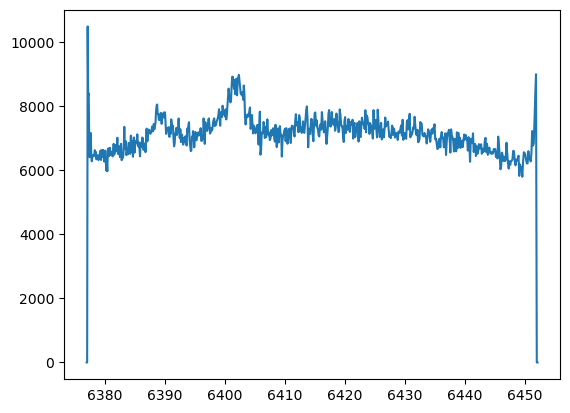

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfx101080524',lcls_run=24)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.key_epix=['epix_1/ROI_0_area']
xes.friendly_name_epix=['epix']
xes.set_key_aliases(keys,names)
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[89,105]]#Ka ROI
#xes.rois=[[78,95]]#Kb ROI
#xes.add_filter('xray','ipm',1.0E2)
#xes.add_filter('simultaneous','ipm',1.0E2)
#xes.add_filter('laser','ipm',1.0E2)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=-1.0
#xes.angle=0
xes.transpose=False
xes.pixels_to_patch=[351,352]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
#xes.run_parser(['112-114','116-117','121-125','128-132']) 
#xes.run_parser(['168-172 177-182']) 
xes.run_parser(['237-239']) 
xes.verbose=False
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=500,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
#v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=42.75, R=250,  mm_per_pixel=0.05, d=0.981)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()


In [23]:
droplets=np.loadtxt('droplets.npy')

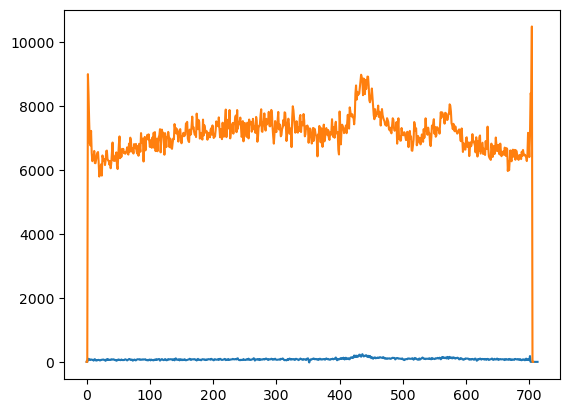

In [9]:
plt.plot(droplets)
plt.plot(v.summed_xes)

In [5]:
all_epix=np.zeros(np.shape(xes.analyzed_runs[-1].epix),dtype=float)
for i in xes.analyzed_runs:
    all_epix=np.nansum([all_epix,i.epix],0)
    

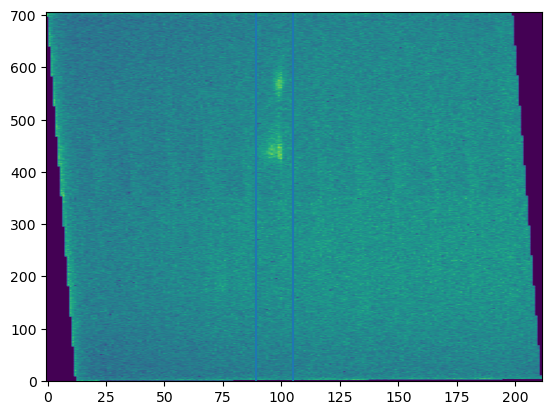

In [7]:
#vmin, vmax = np.nanpercentile(all_epix, [0,99])
plt.imshow(all_epix, origin='lower',aspect='auto')

plt.axvline(89)
plt.axvline(105)

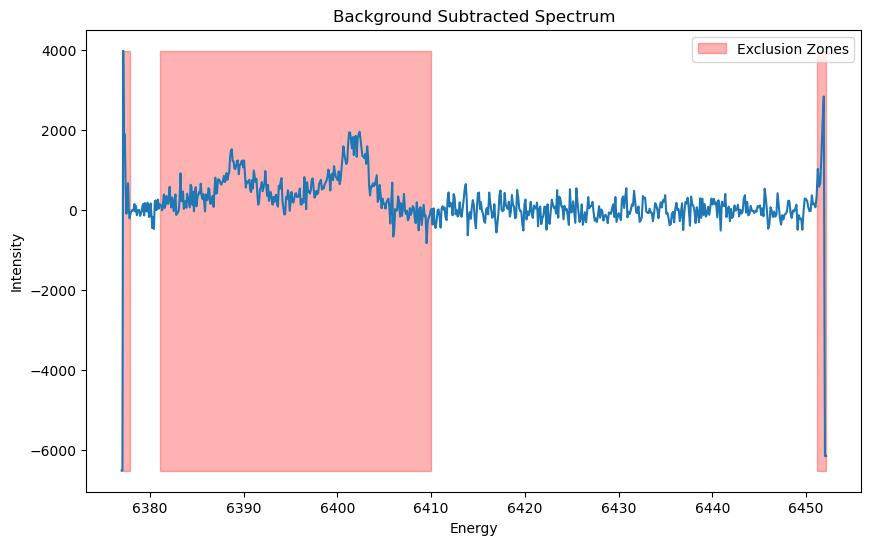

In [24]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,6402,6408)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,6395,6415)
exclusions= (
    (6368, 6378), #edge of detector
    (6381,6410), #Main peaks
    (6451,6465),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()


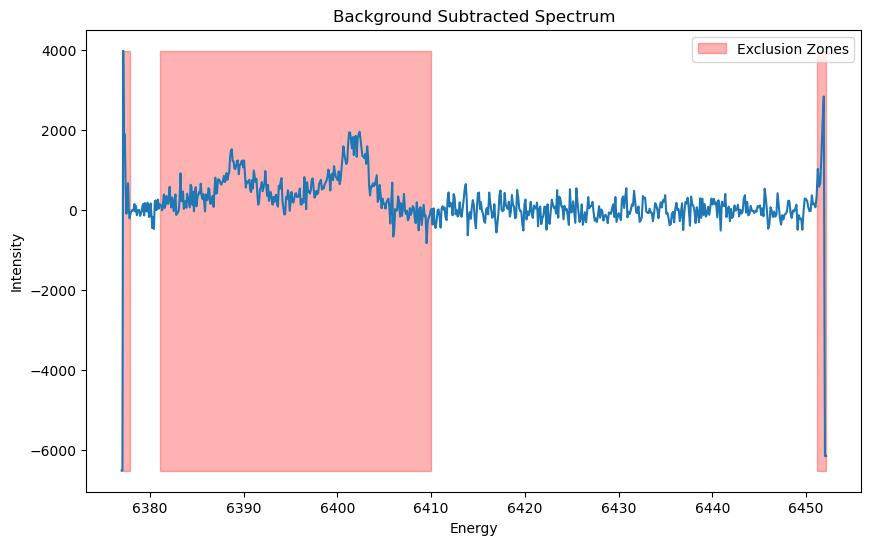

In [25]:
#xes.first_moment=Peaks.first_moment(v.energy,droplets,6402,6408)
#xes.fwhm=Peaks.gaussian_fwhm(v.energy,droplets,6395,6415)
exclusions= (
    (6368, 6378), #edge of detector
    (6381,6410), #Main peaks
    (6451,6465),# other edge of detector
)
v.droplets=Background.polynomial_subtraction(v.energy,droplets[:-12],4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()


Text(0.5, 1.0, 'analysis comparions with droplets runs 237,238,239')

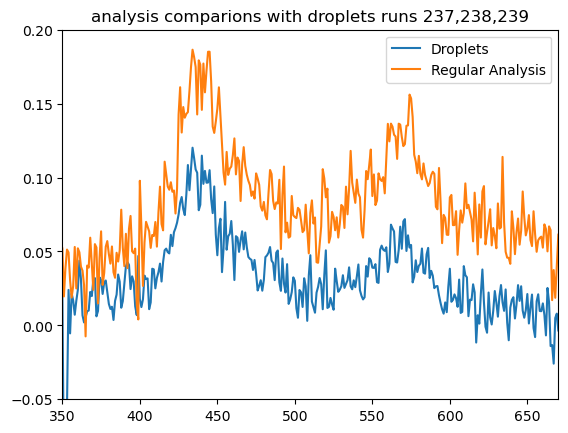

In [31]:

out=v.normalize_spectrum(6384,6410,y=v.droplets)
v.normalize_spectrum(6384,6410)
plt.plot(out)
plt.plot(v.normalized+0.05)
plt.legend(['Droplets','Regular Analysis'])
plt.xlim([400,670])
plt.xlim([350,670])
plt.ylim(-0.05,0.2)
plt.savefig('droplet_comparison.png')
plt.title('analysis comparions with droplets runs 237,238,239')

In [21]:
np.shape(droplets)

(719,)

In [20]:
#First moment calculated after maximum peak normalized to 1
#v.normalize_peak(6386,6418)
#xes.first_moment=Peaks.first_moment(v.energy,v.normalized_peak,6402,6415)
#xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.normalized_peak,6402,6415)
#plt.plot(v.energy,v.normalized_peak)

Text(0, 0.5, 'Normalized Intensity')

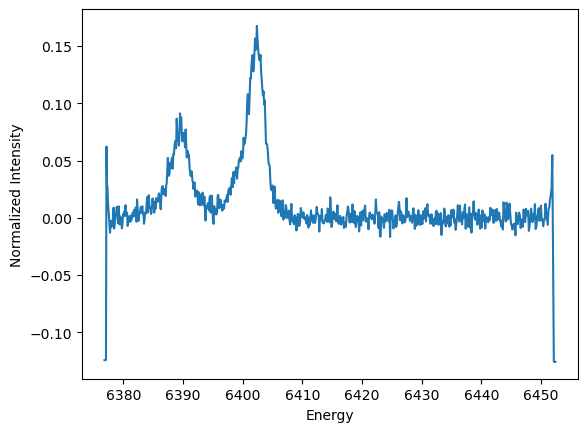

In [14]:
#Normalizes spectrum to make the area under in specified range equal to unity
v.normalize_spectrum(6384,6410)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')


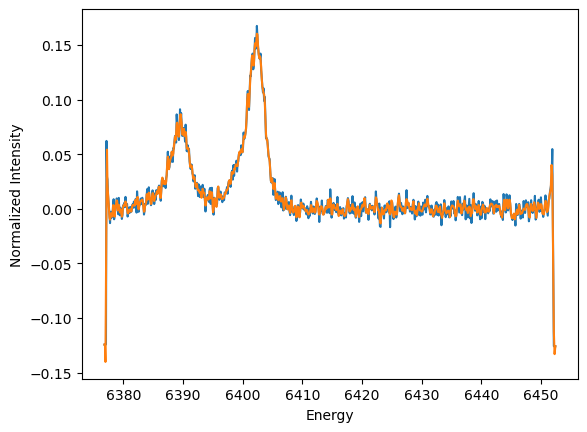

In [15]:
v.smoothed = signal.savgol_filter(v.normalized, window_length=5, polyorder=2, mode="nearest")
plt.plot(v.energy,v.normalized)
plt.plot(v.energy,v.smoothed)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

#Pickles data and analysis files based on above code
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [11]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()

First Moment: 6404.48583943217
FWHM: 22.171189447668507
Run Number: 168
  Total: 6082
  X-ray Total: 6082
  Laser Total: 4055
  XES_Hits: 5356
  Percent_XES_Hits: 88.06%

Run Number: 169
  Total: 3724
  X-ray Total: 3712
  Laser Total: 2473
  XES_Hits: 1421
  Percent_XES_Hits: 38.16%

Run Number: 170
  Total: 3407
  X-ray Total: 3407
  Laser Total: 2272
  XES_Hits: 2816
  Percent_XES_Hits: 82.65%

Run Number: 171
  Total: 5558
  X-ray Total: 5558
  Laser Total: 3705
  XES_Hits: 5040
  Percent_XES_Hits: 90.68%

Run Number: 172
  Total: 5327
  X-ray Total: 5327
  Laser Total: 3551
  XES_Hits: 4416
  Percent_XES_Hits: 82.90%

Run Number: 177
  Total: 4371
  X-ray Total: 4371
  Laser Total: 2914
  XES_Hits: 3520
  Percent_XES_Hits: 80.53%

Run Number: 178
  Total: 7193
  X-ray Total: 7193
  Laser Total: 4796
  XES_Hits: 5843
  Percent_XES_Hits: 81.23%

Run Number: 179
  Total: 7193
  X-ray Total: 7193
  Laser Total: 4796
  XES_Hits: 5666
  Percent_XES_Hits: 78.77%

Run Number: 180
  Total:

In [12]:
#xes.run_parser(['77-89','91-92']) #Red
#xes.run_parser(['93-99','101-102','105-109']) #2s
#xes.run_parser(['112-114','116-117','121-125','128-132']) #1s
with open(f'data_{str(xes.runs)}.pkl', 'rb') as f:
    data_AlkB_O2_2s = pickle.load(f)
   
with open(f'analysis_{str(xes.runs)}.pkl', 'rb') as f:
    analysis_AlkB_O2_2s = pickle.load(f)

In [13]:
plt.plot(analysis_AlkB_Red.energy,analysis_AlkB_Red.normalized)
plt.plot(analysis_AlkB_O2_1s.energy,analysis_AlkB_O2_1s.normalized)
plt.plot(analysis_AlkB_O2_2s.energy,analysis_AlkB_O2_2s.normalized)



NameError: name 'analysis_AlkB_Red' is not defined

In [ ]:
print('Red','1s','2s')
print(data_AlkB_Red.fwhm,data_AlkB_O2_1s.fwhm,data_AlkB_O2_2s.fwhm)
print(data_AlkB_Red.first_moment,data_AlkB_O2_1s.first_moment,data_AlkB_O2_2s.first_moment)

In [ ]:
plt.plot(analysis_AlkB_Red.energy[70:500],analysis_AlkB_Red.normalized[70:500])
plt.plot(analysis_AlkB_O2_1s.energy[70:500],analysis_AlkB_O2_1s.normalized[70:500])
plt.plot(analysis_AlkB_O2_2s.energy[70:500],analysis_AlkB_O2_2s.normalized[70:500])

In [ ]:
plt.

In [ ]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1027922',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[95,110]]
xes.add_filter('xray','ipm',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
xes.run_parser(['230'])
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=43.25, R=250,  mm_per_pixel=0.05, d=0.895)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()

In [ ]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,7030,7072)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,7030,7072)
exclusions= (
    (6980, 6990), #edge of detector
    (7030,7070), #Main peaks
    (7076,7081),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()
with open(f'data_kb__{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_kb_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
v.normalize_spectrum(7030,7070)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()